In [10]:
import os
import glob
import h5py
import shutil
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mimg
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
from pathlib import Path
from skimage.io import imread
from skimage.transform import resize
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import cv2
from keras import backend as K

In [11]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt

from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras_preprocessing.image import ImageDataGenerator


dir = "E:/Design Project Dataset/Tomato Dataset"

train_dir = os.path.join(dir, 'train')
test_dir = os.path.join(dir, 'test')

CATEGORIES = ['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___healthy', 'Tomato___Late_blight', 'Tomato___Late_blight','Tomato___Late_blight','Tomato___Spider_mites Two-spotted_spider_mite','Tomato___Target_Spot','Tomato___Tomato_mosaic_virus','Tomato___Tomato_Yellow_Leaf_Curl_Virus']

train_dataset_size = 0
test_dataset_size = 0

for i in CATEGORIES:
    train_dataset_size += len(os.listdir(os.path.join(train_dir, i)))
    test_dataset_size += len(os.listdir(os.path.join(test_dir, i)))


train_image_generator = ImageDataGenerator(rescale=1./255, rotation_range=45, width_shift_range=.15, height_shift_range=.15, horizontal_flip=True, zoom_range=0.5)
validation_image_generator = ImageDataGenerator(rescale=1./255)

training_datagen = train_image_generator.flow_from_directory(batch_size=16, directory=train_dir, shuffle=True, target_size=(256, 256), class_mode='sparse')

testing_datagen = validation_image_generator.flow_from_directory(batch_size=16, directory=test_dir, shuffle=True, target_size=(256, 256), class_mode='sparse')

Found 17160 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.


In [12]:
def build_model():
    input_img = Input(shape=(256,256,3), name='ImageInput')
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1_1')(input_img)
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1_2')(x)
    x = MaxPooling2D((2,2), name='pool1')(x)

    x = SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv2_1')(x)
    x = SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv2_2')(x)
    x = MaxPooling2D((2,2), name='pool2')(x)

    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_1')(x)
    x = BatchNormalization(name='bn1')(x)
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_2')(x)
    x = BatchNormalization(name='bn2')(x)
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_3')(x)
    x = MaxPooling2D((2,2), name='pool3')(x)

    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_1')(x)
    x = BatchNormalization(name='bn3')(x)
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_2')(x)
    x = BatchNormalization(name='bn4')(x)
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_3')(x)
    x = MaxPooling2D((2,2), name='pool4')(x)

    x = Flatten(name='flatten')(x)
    x = Dense(1024, activation='relu', name='fc1')(x)
    x = Dropout(0.7, name='dropout1')(x)
    x = Dense(512, activation='relu', name='fc2')(x)
    x = Dropout(0.5, name='dropout2')(x)
    x = Dense(10, activation='softmax', name='fc3')(x)

    model = Model(inputs=input_img, outputs=x)
    return model

In [13]:
model =  build_model()
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ImageInput (InputLayer)      [(None, 256, 256, 3)]     0         
_________________________________________________________________
Conv1_1 (Conv2D)             (None, 256, 256, 64)      1792      
_________________________________________________________________
Conv1_2 (Conv2D)             (None, 256, 256, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 128, 128, 64)      0         
_________________________________________________________________
Conv2_1 (SeparableConv2D)    (None, 128, 128, 128)     8896      
_________________________________________________________________
Conv2_2 (SeparableConv2D)    (None, 128, 128, 128)     17664     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 64, 64, 128)       0   

In [14]:
# Open the VGG16 weight file
f = keras.applications.InceptionV3(weights='imagenet', include_top=True)

f.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_188 (Conv2D)             (None, 149, 149, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_188 (BatchN (None, 149, 149, 32) 96          conv2d_188[0][0]                 
__________________________________________________________________________________________________
activation_188 (Activation)     (None, 149, 149, 32) 0           batch_normalization_188[0][0]    
_______________________________________________________________________________________

In [15]:
# Select the layers for which you want to set weight.

#w,b = f['block1_conv1']['block1_conv1_W_1:0'], f['block1_conv1']['block1_conv1_b_1:0']
model.layers[1].set_weights = f.layers[1].output

#w,b = f['block1_conv2']['block1_conv2_W_1:0'], f['block1_conv2']['block1_conv2_b_1:0']
model.layers[2].set_weights = f.layers[4].output

#w,b = f['block2_conv1']['block2_conv1_W_1:0'], f['block2_conv1']['block2_conv1_b_1:0']
model.layers[4].set_weights = f.layers[7].output

#w,b = f['block2_conv2']['block2_conv2_W_1:0'], f['block2_conv2']['block2_conv2_b_1:0']
model.layers[5].set_weights = f.layers[11].output

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ImageInput (InputLayer)      [(None, 256, 256, 3)]     0         
_________________________________________________________________
Conv1_1 (Conv2D)             (None, 256, 256, 64)      1792      
_________________________________________________________________
Conv1_2 (Conv2D)             (None, 256, 256, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 128, 128, 64)      0         
_________________________________________________________________
Conv2_1 (SeparableConv2D)    (None, 128, 128, 128)     8896      
_________________________________________________________________
Conv2_2 (SeparableConv2D)    (None, 128, 128, 128)     17664     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 64, 64, 128)       0   

In [16]:
opt = Adam(lr=0.0001, decay=1e-5);
es = EarlyStopping(patience=20)
chkpt = ModelCheckpoint(filepath='best_model', save_best_only=True, save_weights_only=True)
model.compile(loss='sparse_categorical_crossentropy',metrics=['accuracy'],optimizer=opt)


Epoch 1/75
268/268 [==============================] - 56s 207ms/step - loss: 2.1133 - accuracy: 0.3034 - val_loss: 2.3212 - val_accuracy: 0.1000

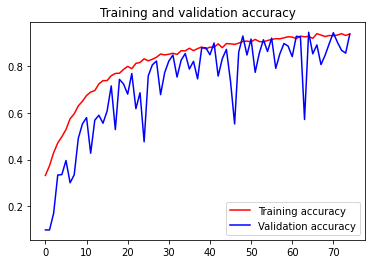

<Figure size 432x288 with 0 Axes>

In [17]:
history = model.fit(training_datagen, epochs=75, steps_per_epoch=17160//64,validation_data=testing_datagen,callbacks=[es,chkpt],batch_size=64)
model.save("graph_inception_V3.h5")

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()